# Laboratorio 3


## Integrantes
- Gustavo Cruz 22779
- Mathew Cordero 22982
- Pedro Guzmán 22111

## Repositorio

[Link al Repositorio](https://github.com/donmatthiuz/ModelacionSimu/tree/lab3)




## Ejercicio 1  

Implementar los siguientes métodos de **descenso gradiente** (naïve = tamaño de paso α constante):  

1. Descenso gradiente naïve con dirección de descenso **aleatoria**.  
2. Descenso gradiente **máximo** naïve.  
3. Descenso gradiente de **Newton**, con Hessiano exacto.  
4. Un método de **gradiente conjugado** (Fletcher-Reeves, Hestenes-Stiefel o Polak-Ribiere).  
5. El método **BFGS**.  

### Requerimientos

En cada uno de los métodos, la función debe recibir los siguientes argumentos:

- La función objetivo `f`.  
- El gradiente de la función objetivo `df`.  
- El Hessiano `ddf` (cuando sea necesario).  
- Un punto inicial `x0 ∈ R^n`.  
- El tamaño de paso `α > 0`.  
- El número máximo de iteraciones `maxIter`.  
- La tolerancia `ε`.  
- Un criterio de paro.  

### Resultados esperados

Los algoritmos deben devolver:  

- La mejor solución encontrada `best` (la última de las aproximaciones calculadas).  
- La secuencia de iteraciones `xk`.  
- La secuencia de valores `f(xk)`.  
- La secuencia de errores en cada paso (según el error de su criterio de paro).  

Además, es deseable indicar:  

- El número de iteraciones efectuadas por el algoritmo.  
- Si se obtuvo o no la **convergencia** del método.  


Lo primero que vamos a hacer es definir una clase con funciones que representan cada metodo|

In [58]:
import numpy as np
import matplotlib.pyplot as plt

class DescensoGradiente:
    def __init__(self, F, df):
        self.F = F     
        self.df = df   

    def plot_results(self, fk, errors, grad_norms, metodo):
        plt.figure(figsize=(18,5))
        
        # --- Evolución de la función F(x) ---
        plt.subplot(1,3,1)
        plt.plot(fk, marker='o')
        plt.title(f"{metodo}: Evolución de F(x)")
        plt.xlabel("Iteración")
        plt.ylabel("F(x)")
        plt.grid(True)
        
        # --- Evolución del error ||Δx|| ---
        plt.subplot(1,3,2)
        plt.plot(errors, marker='o', color='orange')
        plt.title(f"{metodo}: Evolución del error ||Δx||")
        plt.xlabel("Iteración")
        plt.ylabel("||Δx||")
        plt.yscale('log')
        plt.grid(True)
        
        # --- Evolución de la norma del gradiente ||∇f|| ---
        plt.subplot(1,3,3)
        plt.plot(grad_norms, marker='x', color='r')
        plt.title(f"{metodo}: Norma del gradiente ||∇f||")
        plt.xlabel("Iteración")
        plt.ylabel("||∇f||")
        plt.yscale('log')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()


    def steepest_descent(self, x0=np.zeros(2), alpha=0.01, maxIter=10000, tol=1e-10):

        grad_norms = [np.linalg.norm(self.df(x0))]

        
        xk = [np.array(x0, dtype=float)]
        fk = [self.F(x0)]
        errors = [np.linalg.norm(self.df(x0))]
        
        x = np.array(x0, dtype=float)
        
        for k in range(maxIter):
            # Control de overflow/underflow
            if np.any(np.isnan(x)) or np.any(np.isinf(x)):
                print(f"Descenso por Gradiente: Valores numéricos inválidos en iteración {k}")
                break
                
            grad = self.df(x)
            
            # Verificar gradiente válido
            if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
                print(f"Descenso por Gradiente: Gradiente inválido en iteración {k}")
                break
            
            # Criterio de convergencia por gradiente
            if np.linalg.norm(grad) < tol:
                print(f"Descenso por Gradiente: Convergió (gradiente < tol) después de {k} iteraciones")
                self.plot_results(fk, errors,grad_norms, "Descenso por Gradiente")
                return x, xk, fk, errors, k, True
            
            # Actualización con paso fijo
            x_new = x - alpha * grad
            
            try:
                f_new = self.F(x_new)
                if np.isnan(f_new) or np.isinf(f_new):
                    print(f"Descenso por Gradiente: Valor de función inválido en iteración {k}")
                    break
            except:
                print(f"Descenso por Gradiente: Error evaluando función en iteración {k}")
                break
            
            xk.append(x_new.copy())
            fk.append(f_new)
            
            # Error basado en cambio en la función
            error = np.abs(fk[-1] - fk[-2]) if len(fk) > 1 else np.inf
            errors.append(error)
            grad_norms.append(np.linalg.norm( self.df(x)))

            
            # Criterio de convergencia por cambio de función
            if error < tol:
                print(f"Descenso por Gradiente: Convergió (ΔF < tol) después de {k+1} iteraciones")
                self.plot_results(fk, errors, grad_norms, "Descenso por Gradiente")
                return x_new, xk, fk, errors, k+1, True
            
            x = x_new
        
        print("Descenso por Gradiente: No convergió")
        self.plot_results(fk, errors, grad_norms, "Descenso por Gradiente")
        return x, xk, fk, errors, maxIter, False

    def newton_method(self, ddf, x0=np.zeros(2), maxIter=10000, tol=1e-10):
        grad_norms = [np.linalg.norm(self.df(x0))]
        xk = [np.array(x0, dtype=float)]
        fk = [self.F(x0)]
        errors = [np.linalg.norm(self.df(x0))]
        
        x = np.array(x0, dtype=float)
        
        for iteration in range(maxIter):
            # Control de overflow/underflow
            if np.any(np.isnan(x)) or np.any(np.isinf(x)):
                print(f"Método de Newton: Valores numéricos inválidos en iteración {iteration}")
                break
                
            grad = self.df(x)
            
            # Verificar gradiente válido
            if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
                print(f"Método de Newton: Gradiente inválido en iteración {iteration}")
                break
            
            # Criterio de convergencia por gradiente
            if np.linalg.norm(grad) < tol:
                print(f"Método de Newton: Convergió (gradiente < tol) después de {iteration} iteraciones")
                self.plot_results(fk, errors, grad_norms, "Método de Newton")
                return x, xk, fk, errors, iteration, True
            
            # Calcular Hessiano
            try:
                H = ddf(x)
                if np.any(np.isnan(H)) or np.any(np.isinf(H)):
                    print(f"Método de Newton: Hessiano inválido en iteración {iteration}")
                    break
            except:
                print(f"Método de Newton: Error calculando Hessiano en iteración {iteration}")
                break
            
            # Resolver sistema lineal H * delta_x = -grad
            try:
                delta_x = np.linalg.solve(H, -grad)
            except np.linalg.LinAlgError:
                print(f"Método de Newton: Hessiano singular en iteración {iteration}")
                self.plot_results(fk, errors, grad_norms, "Método de Newton")
                return x, xk, fk, errors, iteration, False
            
            # Actualización
            x_new = x + delta_x
            
            try:
                f_new = self.F(x_new)
                if np.isnan(f_new) or np.isinf(f_new):
                    print(f"Método de Newton: Valor de función inválido en iteración {iteration}")
                    break
            except:
                print(f"Método de Newton: Error evaluando función en iteración {iteration}")
                break
            
            xk.append(x_new.copy())
            fk.append(f_new)
            errors.append(np.linalg.norm(delta_x))
            grad_norms.append(np.linalg.norm(self.df(x)))

            
            # Criterio de convergencia por cambio en x
            if np.linalg.norm(delta_x) < tol:
                print(f"Método de Newton: Convergió (Δx < tol) después de {iteration+1} iteraciones")
                self.plot_results(fk, errors, grad_norms, "Método de Newton")
                return x_new, xk, fk, errors, iteration+1, True
            
            x = x_new
        
        print("Método de Newton: No convergió")
        self.plot_results(fk, errors, grad_norms, "Método de Newton")
        return x, xk, fk, errors, maxIter, False

    def naive_random(self, x0=np.zeros(2), alpha=0.01, maxIter=10000, tol=1e-10, 
                     adaptive_alpha=True, accept_prob=0.8, cooling_rate=0.999):
        grad_norms = [np.linalg.norm(self.df(x0))]

       
        xk = [np.array(x0, dtype=float)]
        fk = [self.F(x0)]
        errors = [np.linalg.norm(self.df(x0)) if self.df else np.inf]
        
        x = np.array(x0, dtype=float)
        current_f = fk[0]
        best_x = x.copy()
        best_f = current_f
        alpha_current = alpha
        accept_prob_current = accept_prob
        no_improvement_count = 0
        
        for k in range(maxIter):
            # Control de overflow/underflow
            if np.any(np.isnan(x)) or np.any(np.isinf(x)):
                print(f"Descenso Aleatorio: Valores numéricos inválidos en iteración {k}")
                break
            
            # Estrategia híbrida: combinar direcciones aleatorias con gradiente
            if self.df and k % 10 == 0 and k > 0:
                # Cada 10 iteraciones, usar dirección del gradiente con ruido
                grad = self.df(x)
                if not (np.any(np.isnan(grad)) or np.any(np.isinf(grad))):
                    grad_norm = np.linalg.norm(grad)
                    if grad_norm > 1e-12:
                        d_gradient = -grad / grad_norm
                        d_random = np.random.randn(*x.shape)
                        d_random = d_random / np.linalg.norm(d_random)
                        # Combinar 70% gradiente, 30% aleatorio
                        d = 0.7 * d_gradient + 0.3 * d_random
                        d = d / np.linalg.norm(d)
                    else:
                        d = np.random.randn(*x.shape)
                        d = d / np.linalg.norm(d)
                else:
                    d = np.random.randn(*x.shape)
                    d = d / np.linalg.norm(d)
            else:
                # Dirección completamente aleatoria
                d = np.random.randn(*x.shape)
                d = d / np.linalg.norm(d)
            
            # Probar múltiples pasos con backtracking
            step_sizes = [alpha_current, alpha_current * 0.5, alpha_current * 2.0, alpha_current * 0.1]
            best_step_f = np.inf
            best_step_x = None
            
            for step in step_sizes:
                x_candidate = x + step * d
                
                # Clipping para evitar valores extremos
                x_candidate = np.clip(x_candidate, -50, 50)
                
                try:
                    f_candidate = self.F(x_candidate)
                    if not (np.isnan(f_candidate) or np.isinf(f_candidate)):
                        if f_candidate < best_step_f:
                            best_step_f = f_candidate
                            best_step_x = x_candidate.copy()
                except:
                    continue
            
            # Si no se encontró un paso válido, intentar dirección opuesta
            if best_step_x is None:
                d = -d
                for step in step_sizes:
                    x_candidate = x + step * d
                    x_candidate = np.clip(x_candidate, -50, 50)
                    try:
                        f_candidate = self.F(x_candidate)
                        if not (np.isnan(f_candidate) or np.isinf(f_candidate)):
                            if f_candidate < best_step_f:
                                best_step_f = f_candidate
                                best_step_x = x_candidate.copy()
                    except:
                        continue
            
            # Si aún no hay paso válido, reducir alpha y continuar
            if best_step_x is None:
                alpha_current *= 0.5
                if alpha_current < 1e-12:
                    print(f"Descenso Aleatorio: Alpha demasiado pequeño en iteración {k}")
                    break
                continue
            
            # Criterio de aceptación mejorado
            accept_move = False
            
            if best_step_f < current_f:
                # Mejora: siempre aceptar
                accept_move = True
                no_improvement_count = 0
            else:
                # No mejora: aceptar con cierta probabilidad (simulated annealing)
                if np.random.random() < accept_prob_current:
                    accept_move = True
                no_improvement_count += 1
            
            if accept_move:
                x = best_step_x
                current_f = best_step_f
                
                # Actualizar mejor solución encontrada
                if current_f < best_f:
                    best_f = current_f
                    best_x = x.copy()
            
            xk.append(x.copy())
            fk.append(current_f)
            
            # Calcular error
            if self.df:
                try:
                    grad = self.df(x)
                    if not (np.any(np.isnan(grad)) or np.any(np.isinf(grad))):
                        error = np.linalg.norm(grad)
                    else:
                        error = np.abs(fk[-1] - fk[-2]) if len(fk) > 1 else np.inf
                except:
                    error = np.abs(fk[-1] - fk[-2]) if len(fk) > 1 else np.inf
            else:
                error = np.abs(fk[-1] - fk[-2]) if len(fk) > 1 else np.inf
            
            errors.append(error)
            grad_norms.append(np.linalg.norm(self.df(x)))

            
            # Criterio de convergencia mejorado
            if len(fk) > 10:
                # Convergencia basada en estabilidad de la función
                recent_values = fk[-10:]
                if max(recent_values) - min(recent_values) < tol:
                    print(f"Descenso Aleatorio: Convergió después de {k+1} iteraciones (estabilidad)")
                    self.plot_results(fk, errors, grad_norms, "Descenso Aleatorio")
                    return best_x, xk, fk, errors, k+1, True
            
            # Convergencia por gradiente pequeño
            if error < tol:
                print(f"Descenso Aleatorio: Convergió después de {k+1} iteraciones (gradiente)")
                self.plot_results(fk, errors,grad_norms, "Descenso Aleatorio")
                return best_x, xk, fk, errors, k+1, True
            
            # Ajustes adaptativos
            if adaptive_alpha:
                if no_improvement_count > 50:
                    alpha_current *= 1.1  # Aumentar paso si no hay mejora
                elif no_improvement_count == 0:
                    alpha_current *= cooling_rate  # Reducir gradualmente
            
            # Reducir probabilidad de aceptación gradualmente
            accept_prob_current *= cooling_rate
            accept_prob_current = max(accept_prob_current, 0.01)
            
            # Restart si no hay mejora por mucho tiempo
            if no_improvement_count > 200:
                x = best_x + 0.1 * np.random.randn(*x.shape)
                x = np.clip(x, -50, 50)
                current_f = self.F(x)
                no_improvement_count = 0
                alpha_current = alpha
                print(f"Restart en iteración {k}")
        
        print("Descenso Aleatorio: No convergió")
        self.plot_results(fk, errors, grad_norms,"Descenso Aleatorio")
        return best_x, xk, fk, errors, maxIter, False

    def conjugate_gradient_flerev(self, x0=np.zeros(2), alpha=0.01, maxIter=1000, tol=1e-10):
        xk = [np.array(x0, dtype=float)]
        fk = [self.F(x0)]
        errors = [np.linalg.norm(self.df(x0))]
        grad_norms = [np.linalg.norm(self.df(x0))]


        x = np.array(x0, dtype=float)
        grad = self.df(x)
        d = -grad

        for k in range(maxIter):
            # Control de overflow/underflow
            if np.any(np.isnan(x)) or np.any(np.isinf(x)):
                print(f"Fletcher-Reeves: Valores numéricos inválidos en iteración {k}")
                break
                
            grad_old = grad.copy()
            
            # Paso adaptativo más conservador
            step_size = alpha
            x_new = x + step_size * d
            
            # Verificar si el paso es demasiado grande
            max_attempts = 10
            attempts = 0
            while attempts < max_attempts:
                try:
                    f_new = self.F(x_new)
                    if np.isnan(f_new) or np.isinf(f_new):
                        step_size *= 0.5
                        x_new = x + step_size * d
                        attempts += 1
                    else:
                        break
                except:
                    step_size *= 0.5
                    x_new = x + step_size * d
                    attempts += 1
            
            if attempts >= max_attempts:
                print(f"Fletcher-Reeves: No se pudo encontrar un paso válido en iteración {k}")
                break
            
            grad = self.df(x_new)
            
            # Verificar convergencia numérica
            if np.any(np.isnan(grad)) or np.any(np.isinf(grad)):
                print(f"Fletcher-Reeves: Gradiente inválido en iteración {k}")
                break

            xk.append(x_new.copy())
            fk.append(f_new)
            errors.append(np.linalg.norm(grad))
            grad_norms.append(np.linalg.norm(grad))


            if np.linalg.norm(grad) < tol:
                print(f"Gradiente Conjugado (Fletcher-Reeves): Convergió después de {k+1} iteraciones")
                self.plot_results(fk, errors,grad_norms, "Gradiente Conjugado (F-R)")
                return x_new, xk, fk, errors, k+1, True

            # Calcular beta con protección numérica
            grad_old_norm_sq = np.dot(grad_old, grad_old)
            if grad_old_norm_sq > 1e-12:
                beta = np.dot(grad, grad) / grad_old_norm_sq
                beta = np.clip(beta, 0, 10)  # Limitar beta
            else:
                beta = 0
                
            d = -grad + beta * d
            
            # Limitar la norma de la dirección
            d_norm = np.linalg.norm(d)
            if d_norm > 100:
                d = d / d_norm * 100
                
            x = x_new

        print("Gradiente Conjugado (Fletcher-Reeves): No convergió")
        self.plot_results(fk, errors,grad_norms, "Gradiente Conjugado (F-R)")
        return x, xk, fk, errors, maxIter, False

    def bfgs_method(self, x0=np.zeros(2), tol=1e-6, maxIter=1000):
        x = np.array(x0, dtype=float)
        n = len(x)
        H = np.eye(n)
        xk = [x.copy()]
        fk = [self.F(x)]
        errors = [np.linalg.norm(self.df(x))]
        grad_norms = [np.linalg.norm(self.df(x0))]


        for k in range(maxIter):
            grad = self.df(x)
            if np.linalg.norm(grad) < tol:
                print(f"BFGS: Convergió (‖grad‖ < tol) en {k} iteraciones")
                self.plot_results(fk, errors, grad_norms,  "BFGS")
                return x, xk, fk, errors, k, True

            # Dirección de descenso
            d = -H.dot(grad)

            # --- Backtracking Armijo ---
            alpha = 1.0
            rho, c = 0.8, 1e-4
            f_x = self.F(x)
            while self.F(x + alpha*d) > f_x + c*alpha*np.dot(grad, d):
                alpha *= rho

            s = alpha * d
            x_new = x + s
            grad_new = self.df(x_new)

            # Actualización BFGS
            y = grad_new - grad
            sy = np.dot(s, y)
            if sy > 1e-10:
                rho = 1.0 / sy
                I = np.eye(n)
                V = I - rho * np.outer(s, y)
                H = V.dot(H).dot(V.T) + rho * np.outer(s, s)

            # Guardar info
            x, fval = x_new, self.F(x_new)
            xk.append(x.copy())
            fk.append(fval)
            errors.append(np.linalg.norm(grad_new))
            grad_norms.append(np.linalg.norm(grad_new))


            if np.linalg.norm(s) < tol:
                print(f"BFGS: Convergió (‖Δx‖ < tol) en {k+1} iteraciones")
                self.plot_results(fk, errors,grad_norms, "BFGS")
                return x, xk, fk, errors, k+1, True

        print("BFGS: No convergió")
        self.plot_results(fk, errors,grad_norms, "BFGS")
        return x, xk, fk, errors, maxIter, False


Ahora creamos la funcion para generar los graficos de nivel



In [59]:
def visualizar_iteraciones(func, xk, levels=30, title="Convergencia al mínimo local"):
   
    xk = np.array(xk)  # Asegurar que es array
    x_vals = np.linspace(np.min(xk[:,0]) - 1, np.max(xk[:,0]) + 1, 400)
    y_vals = np.linspace(np.min(xk[:,1]) - 1, np.max(xk[:,1]) + 1, 400)
    X, Y = np.meshgrid(x_vals, y_vals)

    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func([X[i, j], Y[i, j]])

    plt.figure(figsize=(6,6))
    plt.contour(X, Y, Z, levels=levels, cmap="viridis")

    plt.plot(xk[:,0], xk[:,1], "r.-", label="iterates")

    plt.plot(xk[0,0], xk[0,1], "bo", label="start")
    plt.plot(xk[-1,0], xk[-1,1], "ko", label="solution")

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title(title)
    plt.legend()
    plt.grid(False)
    plt.show()


## Ejercicio 2

Testar sus algoritmos del Ejercicio 1 con las siguientes funciones:


a) La función $f : \mathbb{R}^2 \to \mathbb{R}$, dada por:

$$
f(x, y) = x^4 + y^4 - 4xy + \frac{1}{2}y + 1
$$

* Punto inicial: $\mathbf{x}_0 = (-3, 1, -3, 1)^T$
* Óptimo: $\mathbf{x}^* = (-1.01463, -1.04453)^T$, $f(\mathbf{x}^*) = -1.51132$


EJERCICIO 2a) Función: f(x,y) = x⁴ + y⁴ - 4xy + (1/2)y + 1
Punto inicial: [-1.   0.5]
Óptimo teórico: [-1.01463 -1.04453]
Valor óptimo teórico: -1.51132
Valor inicial: 4.312500

DESCENSO POR GRADIENTE MAXMO
--------------------------------------------------
Descenso por Gradiente: Convergió (ΔF < tol) después de 1012 iteraciones


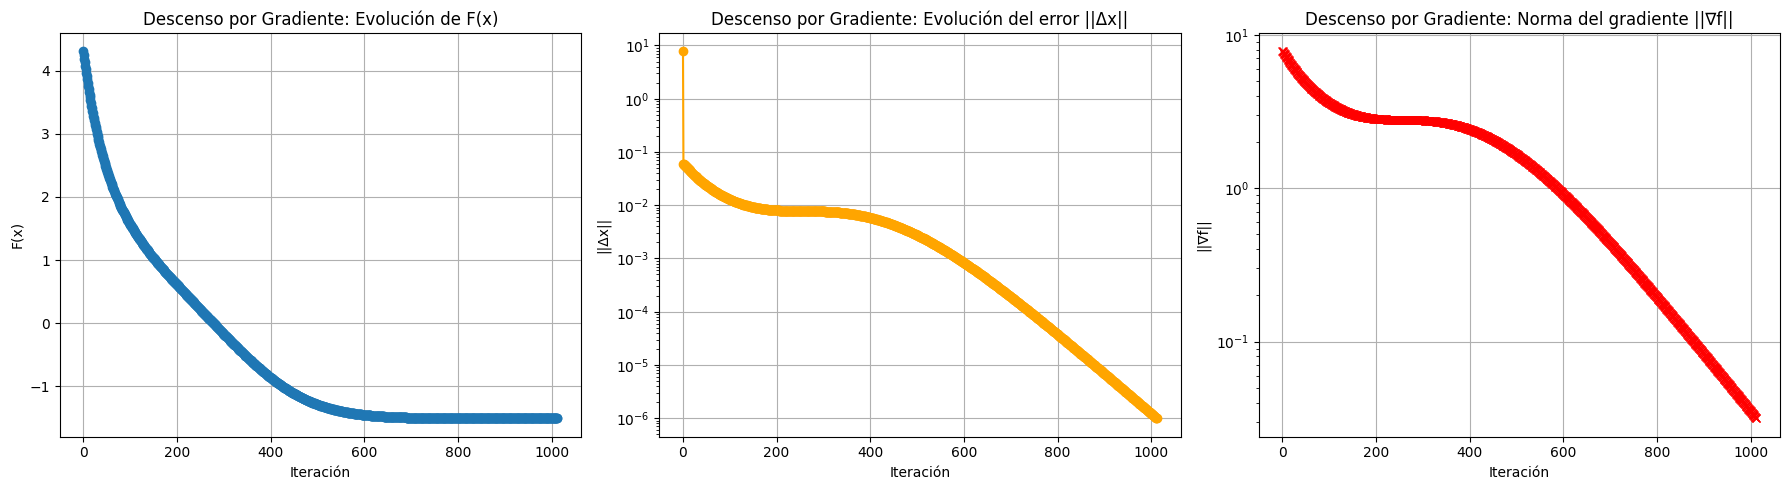

Resultado: [-1.011964, -1.042096]
Valor función: -1.511263
Error vs óptimo teórico: 0.003610
Iteraciones: 1012, Convergió: True

MÉTODO DE NEWTON
--------------------------------------------------
Método de Newton: Convergió (gradiente < tol) después de 5 iteraciones


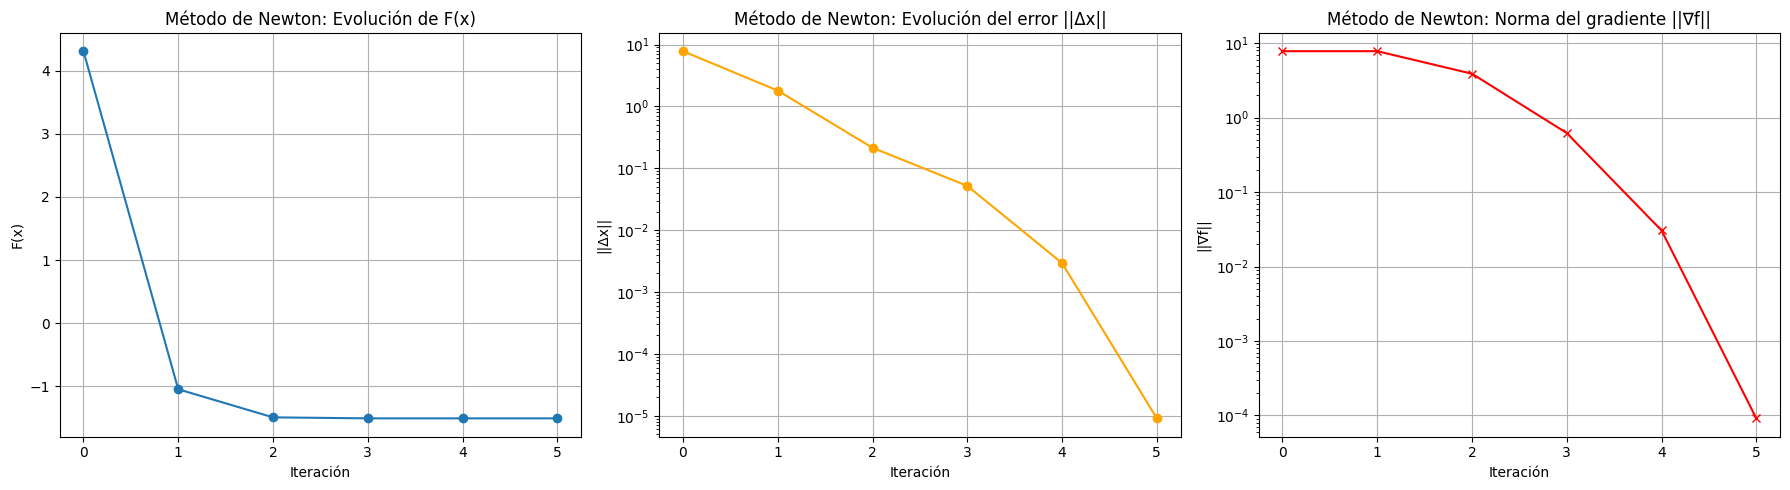

Resultado: [-1.014628, -1.044530]
Valor función: -1.511319
Error vs óptimo teórico: 0.000002
Iteraciones: 5, Convergió: True

DESCENSO ALEATORIO
--------------------------------------------------
Descenso Aleatorio: Convergió después de 710 iteraciones (estabilidad)


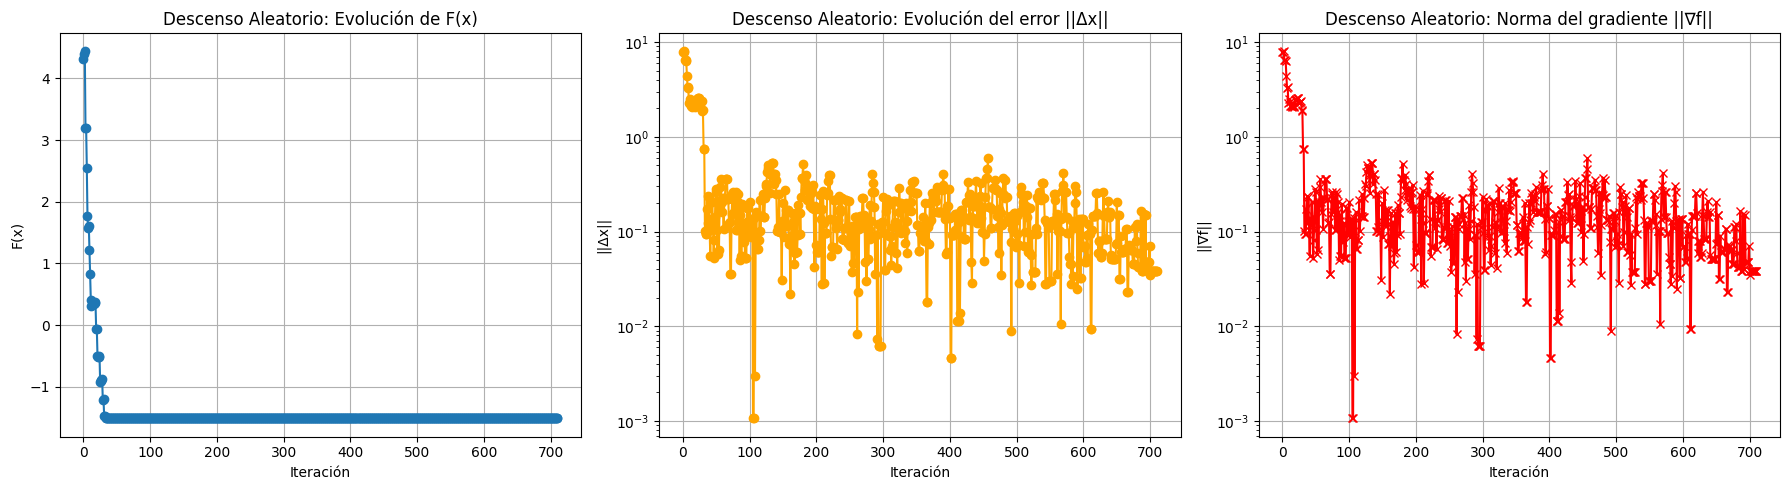

Resultado: [-1.014727, -1.044573]
Valor función: -1.511319
Error vs óptimo teórico: 0.000107
Iteraciones: 710, Convergió: True

FLETCHER-REEVES
--------------------------------------------------
Gradiente Conjugado (Fletcher-Reeves): Convergió después de 664 iteraciones


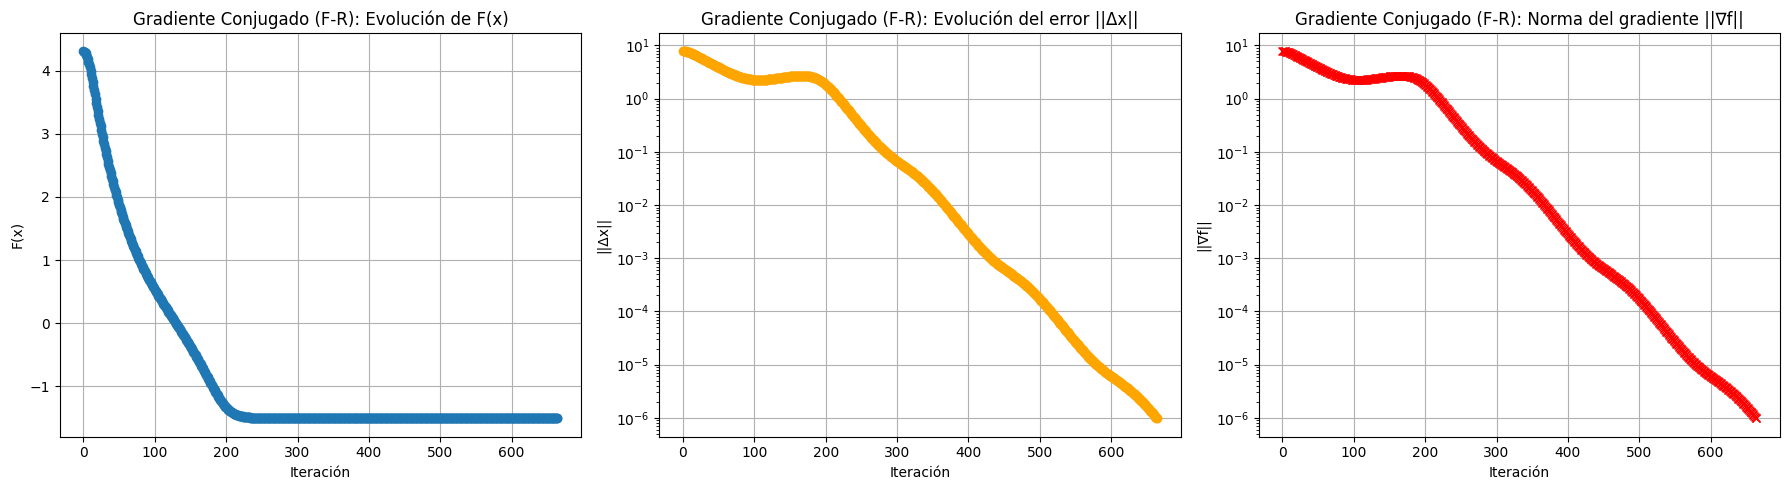

Resultado: [-1.014628, -1.044530]
Valor función: -1.511319
Error vs óptimo teórico: 0.000002
Iteraciones: 664, Convergió: True

BFGS
--------------------------------------------------
BFGS: Convergió (‖grad‖ < tol) en 11 iteraciones


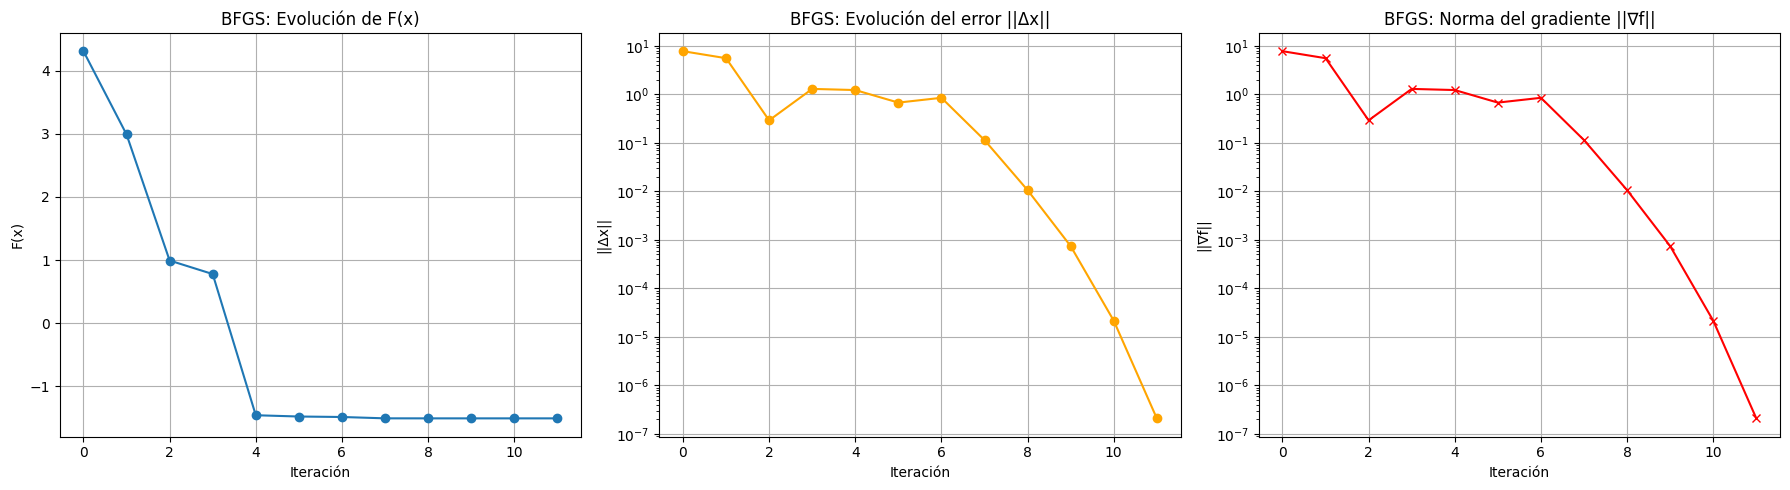

Resultado: [-1.014628, -1.044530]
Valor función: -1.511319
Error vs óptimo teórico: 0.000002
Iteraciones: 11, Convergió: True
--------------------------------------------------
Graficos de Nivel


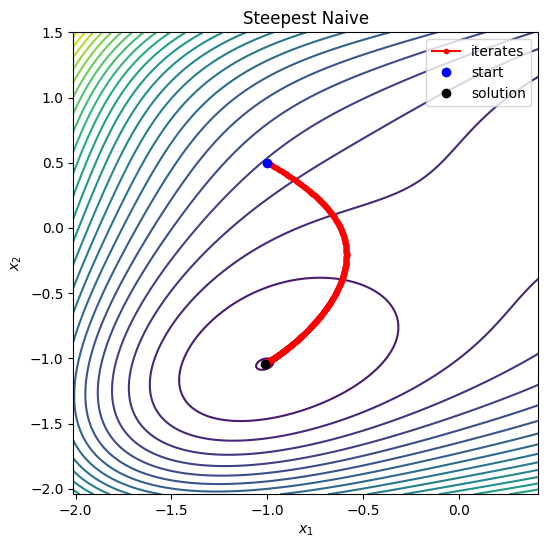

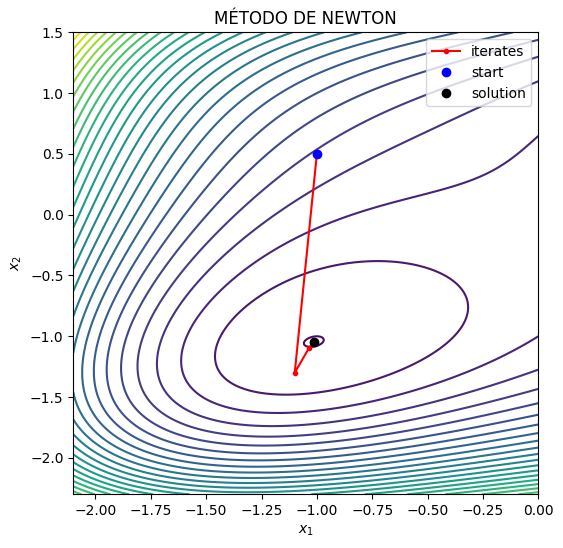

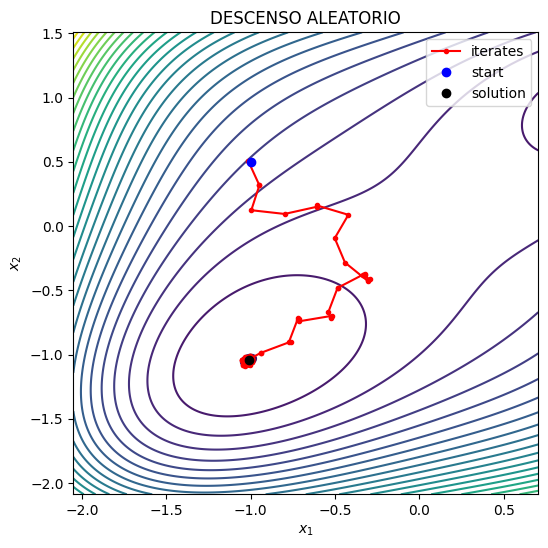

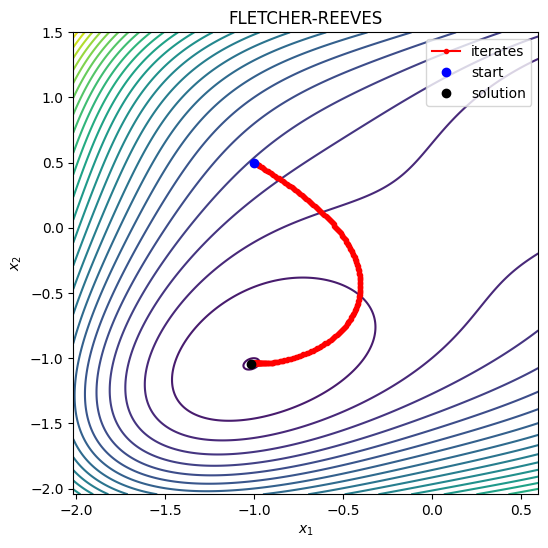

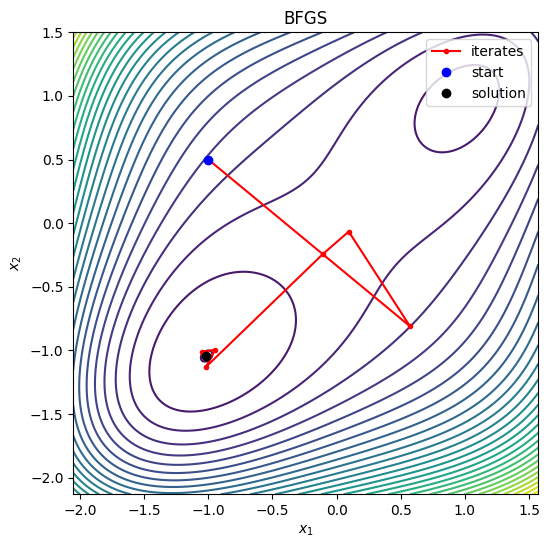

In [60]:
def funcion_a(x):
    x = np.clip(x, -50, 50)
    return x[0]**4 + x[1]**4 - 4*x[0]*x[1] + 0.5*x[1] + 1

def funcion_a_grad(x):
    x = np.clip(x, -50, 50)
    dfdx = 4*x[0]**3 - 4*x[1]
    dfdy = 4*x[1]**3 - 4*x[0] + 0.5
    return np.array([dfdx, dfdy])

def funcion_a_hess(x):
    x = np.clip(x, -50, 50)
    d2fdx2 = 12*x[0]**2
    d2fdy2 = 12*x[1]**2
    d2fdxdy = -4
    return np.array([[d2fdx2, d2fdxdy], [d2fdxdy, d2fdy2]])

def test_funcion_a_completo():
    print("="*80)
    print("EJERCICIO 2a) Función: f(x,y) = x⁴ + y⁴ - 4xy + (1/2)y + 1")
    print("="*80)
    
    x0 = np.array([-1.0, 0.5])
    x_optimo_teorico = np.array([-1.01463, -1.04453])
    f_optimo_teorico = -1.51132
    
    print(f"Punto inicial: {x0}")
    print(f"Óptimo teórico: {x_optimo_teorico}")
    print(f"Valor óptimo teórico: {f_optimo_teorico:.5f}")
    print(f"Valor inicial: {funcion_a(x0):.6f}")
    print()
    
    optimizer = DescensoGradiente(funcion_a, funcion_a_grad)
    
    # DESCENSO POR GRADIENTE MAXMO
    print("DESCENSO POR GRADIENTE MAXMO")
    print("-" * 50)
    x_opt_grad, stps_xk, _, _, iter_grad, conv_grad = optimizer.steepest_descent(
        x0=x0, alpha=0.001, maxIter=5000, tol=1e-6
    )


    

    if not np.any(np.isnan(x_opt_grad)):
        print(f"Resultado: [{x_opt_grad[0]:.6f}, {x_opt_grad[1]:.6f}]")
        print(f"Valor función: {funcion_a(x_opt_grad):.6f}")
        print(f"Error vs óptimo teórico: {np.linalg.norm(x_opt_grad - x_optimo_teorico):.6f}")
    print(f"Iteraciones: {iter_grad}, Convergió: {conv_grad}")
    print()
    
    # Método de Newton
    print("MÉTODO DE NEWTON")
    print("-" * 50)
    x_opt_newton, newton_xk, _, _, iter_newton, conv_newton = optimizer.newton_method(
        ddf=funcion_a_hess, x0=x0, maxIter=1000, tol=1e-6
    )
    if not np.any(np.isnan(x_opt_newton)):
        print(f"Resultado: [{x_opt_newton[0]:.6f}, {x_opt_newton[1]:.6f}]")
        print(f"Valor función: {funcion_a(x_opt_newton):.6f}")
        print(f"Error vs óptimo teórico: {np.linalg.norm(x_opt_newton - x_optimo_teorico):.6f}")
    print(f"Iteraciones: {iter_newton}, Convergió: {conv_newton}")
    print()
    
    # Descenso Aleatorio
    print("DESCENSO ALEATORIO")
    print("-" * 50)
    x_opt_rand, aleatorio_xk, _, _, iter_rand, conv_rand = optimizer.naive_random(
        x0=x0, alpha=0.1, maxIter=5000, tol=1e-6
    )
    if not np.any(np.isnan(x_opt_rand)):
        print(f"Resultado: [{x_opt_rand[0]:.6f}, {x_opt_rand[1]:.6f}]")
        print(f"Valor función: {funcion_a(x_opt_rand):.6f}")
        print(f"Error vs óptimo teórico: {np.linalg.norm(x_opt_rand - x_optimo_teorico):.6f}")
    print(f"Iteraciones: {iter_rand}, Convergió: {conv_rand}")
    print()
    
    # Fletcher-Reeves
    print("FLETCHER-REEVES")
    print("-" * 50)
    x_opt_fr, fr_xk, _, _, iter_fr, conv_fr = optimizer.conjugate_gradient_flerev(
        x0=x0, alpha=0.0001, maxIter=5000, tol=1e-6
    )
    if not np.any(np.isnan(x_opt_fr)):
        print(f"Resultado: [{x_opt_fr[0]:.6f}, {x_opt_fr[1]:.6f}]")
        print(f"Valor función: {funcion_a(x_opt_fr):.6f}")
        print(f"Error vs óptimo teórico: {np.linalg.norm(x_opt_fr - x_optimo_teorico):.6f}")
    print(f"Iteraciones: {iter_fr}, Convergió: {conv_fr}")
    print()
    
    # BFGS
    print("BFGS")
    print("-" * 50)
    x_opt_bfgs, bfgs_xk, _, _, iter_bfgs, conv_bfgs = optimizer.bfgs_method(
        x0=x0, tol=1e-6, maxIter=5000
    )
    if not np.any(np.isnan(x_opt_bfgs)):
        print(f"Resultado: [{x_opt_bfgs[0]:.6f}, {x_opt_bfgs[1]:.6f}]")
        print(f"Valor función: {funcion_a(x_opt_bfgs):.6f}")
        print(f"Error vs óptimo teórico: {np.linalg.norm(x_opt_bfgs - x_optimo_teorico):.6f}")
    print(f"Iteraciones: {iter_bfgs}, Convergió: {conv_bfgs}")


    print("-" * 50)
    print("Graficos de Nivel")
    visualizar_iteraciones(funcion_a, stps_xk, title="Steepest Naive")

    visualizar_iteraciones(funcion_a, newton_xk, title="MÉTODO DE NEWTON")

    visualizar_iteraciones(funcion_a, aleatorio_xk, title="DESCENSO ALEATORIO")

    visualizar_iteraciones(funcion_a, fr_xk, title="FLETCHER-REEVES")

    visualizar_iteraciones(funcion_a, bfgs_xk, title="BFGS")


test_funcion_a_completo()





b) La función de Rosenbrock 2-dimensional $f : \mathbb{R}^2 \to \mathbb{R}$, dada por:

$$
f(x_1, x_2) = 100(x_2 - x_1^2)^2 + (1 - x_1)^2
$$

* Punto inicial: $\mathbf{x}_0 = (-1.2, 1)^T$
* Óptimo: $\mathbf{x}^* = (1,1)^T$, $f(\mathbf{x}^*) = 0$





EJERCICIO 2b) Función de Rosenbrock 2D
Punto inicial: [-1.2  1. ]
Óptimo teórico: [1. 1.]
Valor inicial: 24.200000

DESCENSO POR GRADIENTE MAXIMO
--------------------------------------------------
Descenso por Gradiente: Convergió (ΔF < tol) después de 3867 iteraciones


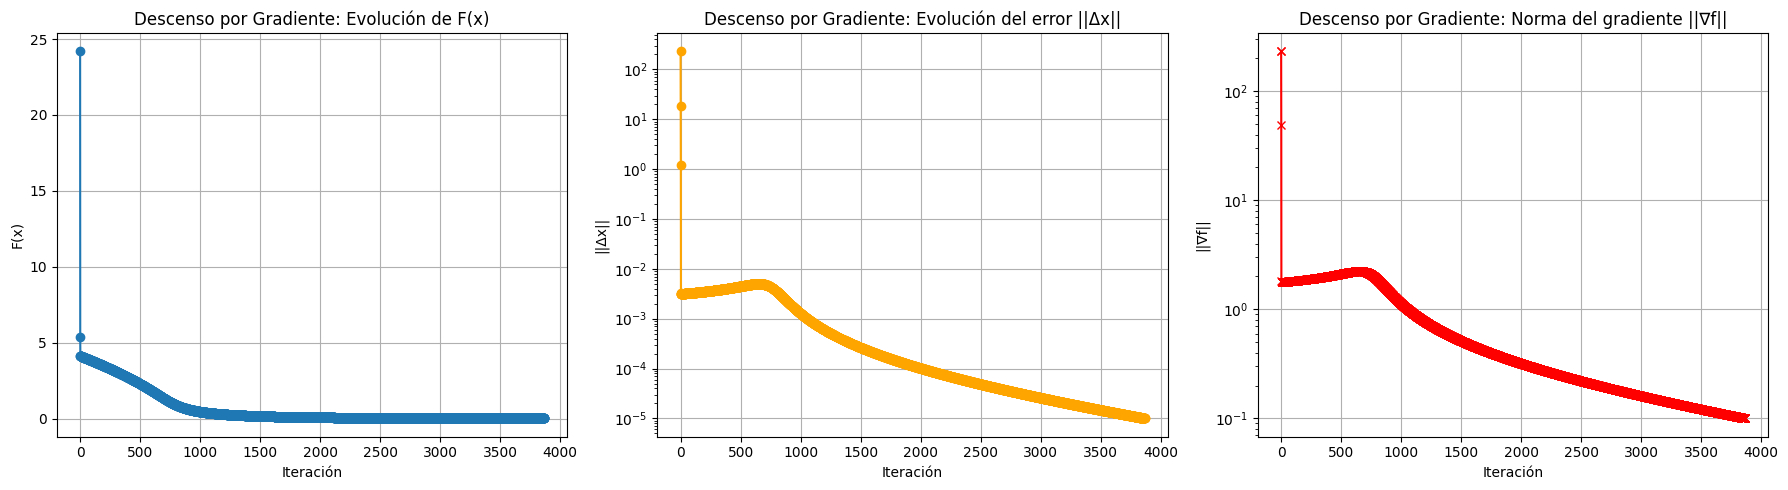

Resultado: [0.897351, 0.804803]
Valor función: 0.010556
Error vs óptimo teórico: 0.220542
Iteraciones: 3867, Convergió: True

MÉTODO DE NEWTON
--------------------------------------------------
Método de Newton: Convergió (gradiente < tol) después de 6 iteraciones


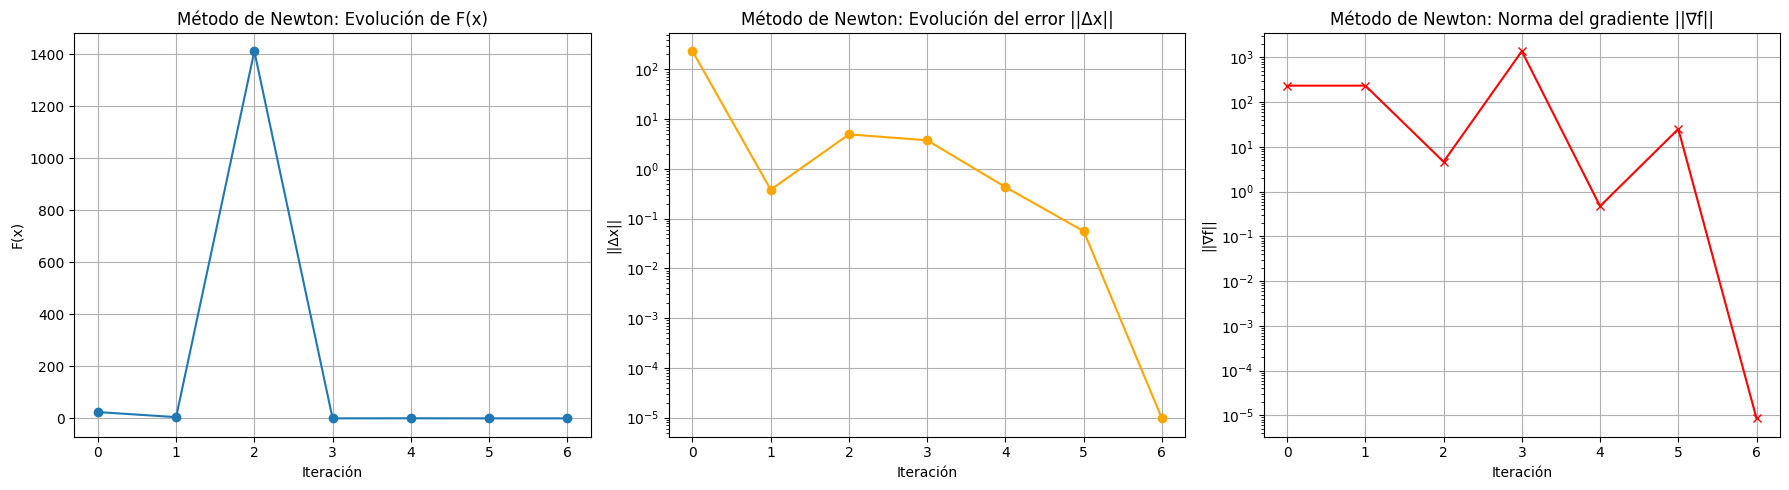

Resultado: [1.000000, 1.000000]
Valor función: 0.000000
Error vs óptimo teórico: 0.000000
Iteraciones: 6, Convergió: True

DESCENSO ALEATORIO
--------------------------------------------------
Descenso Aleatorio: Convergió después de 1431 iteraciones (estabilidad)


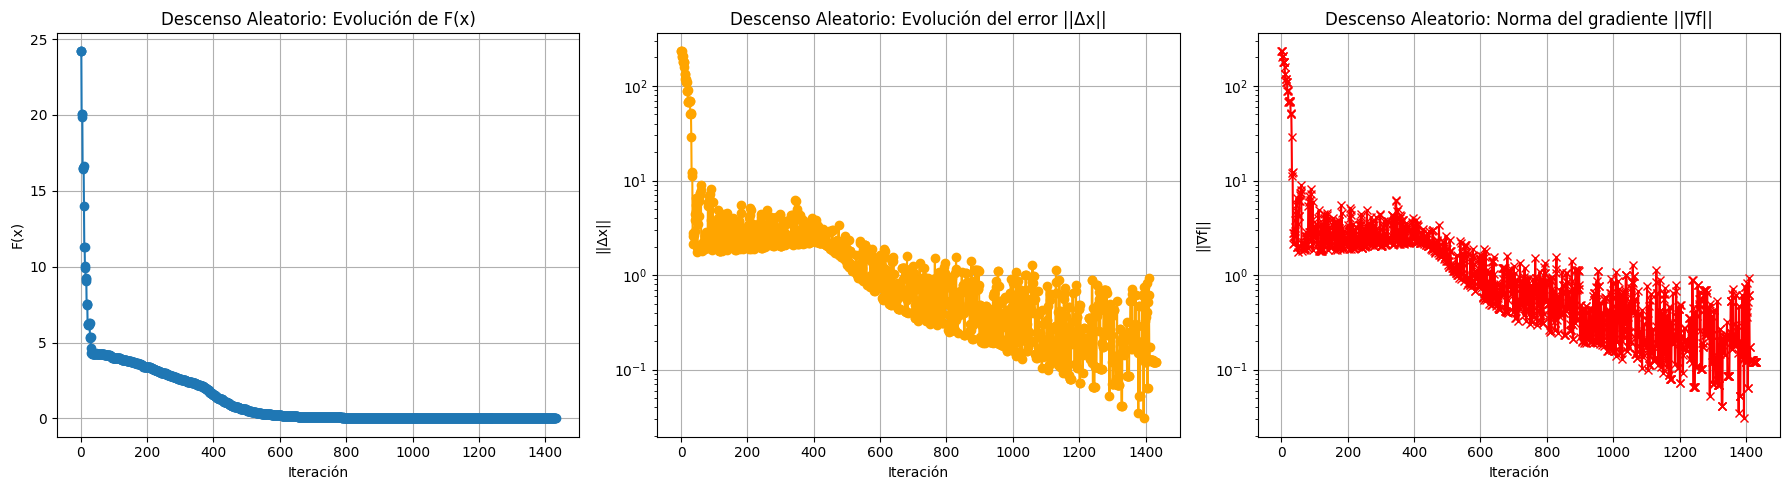

Resultado: [0.966725, 0.934420]
Valor función: 0.001109
Error vs óptimo teórico: 0.073539
Iteraciones: 1431, Convergió: True

FLETCHER-REEVES
--------------------------------------------------
Gradiente Conjugado (Fletcher-Reeves): Convergió después de 718 iteraciones


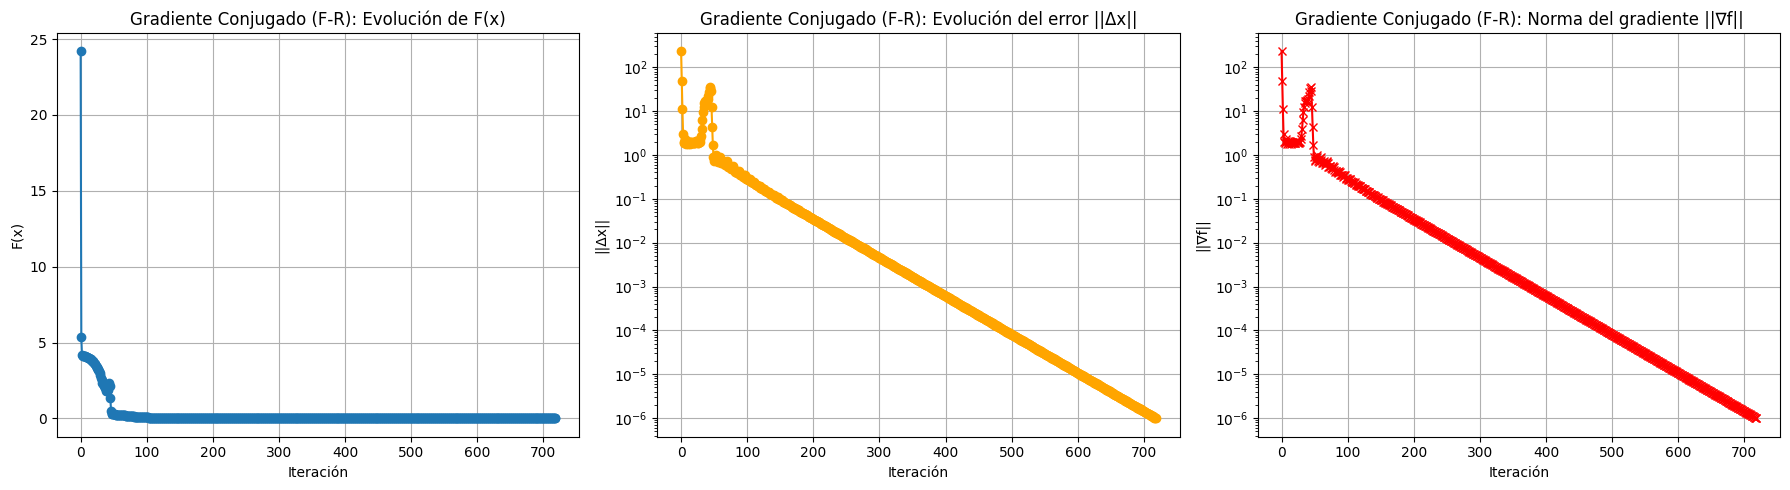

Resultado: [0.999999, 0.999998]
Valor función: 0.000000
Error vs óptimo teórico: 0.000002
Iteraciones: 718, Convergió: True

BFGS
--------------------------------------------------
BFGS: Convergió (‖Δx‖ < tol) en 22 iteraciones


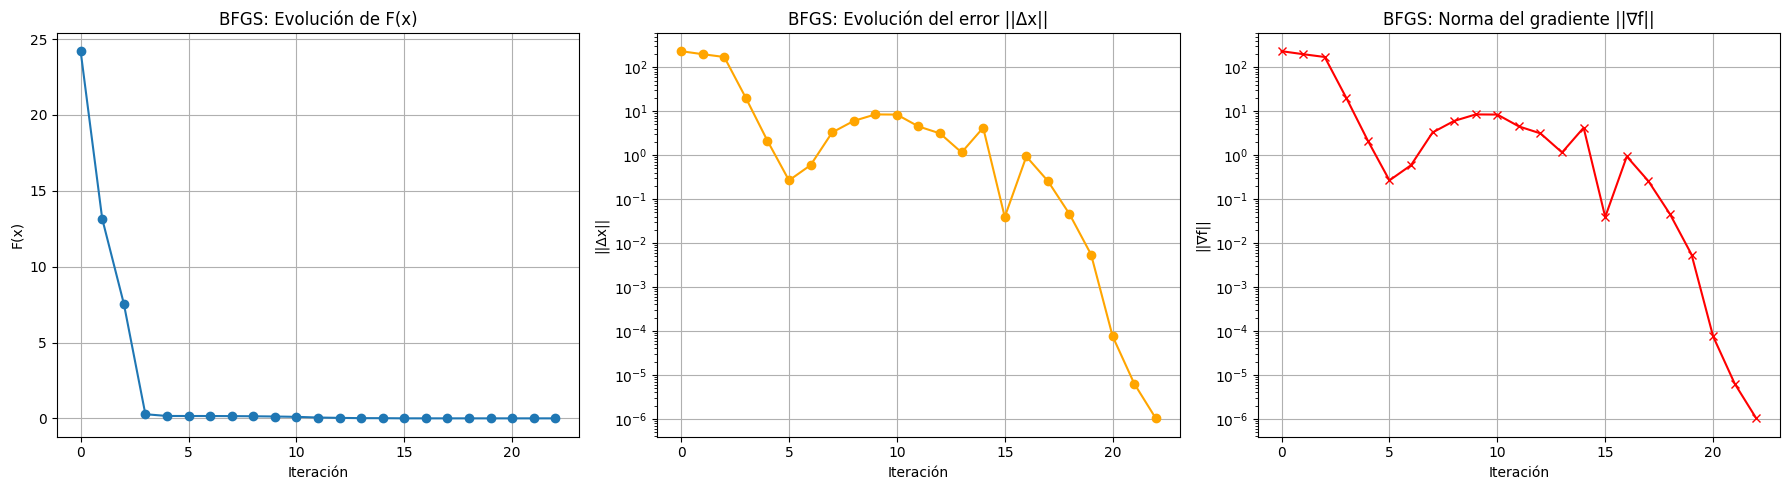

Resultado: [1.000000, 1.000000]
Valor función: 0.000000
Error vs óptimo teórico: 0.000000
Iteraciones: 22, Convergió: True
--------------------------------------------------
Graficos de Nivel


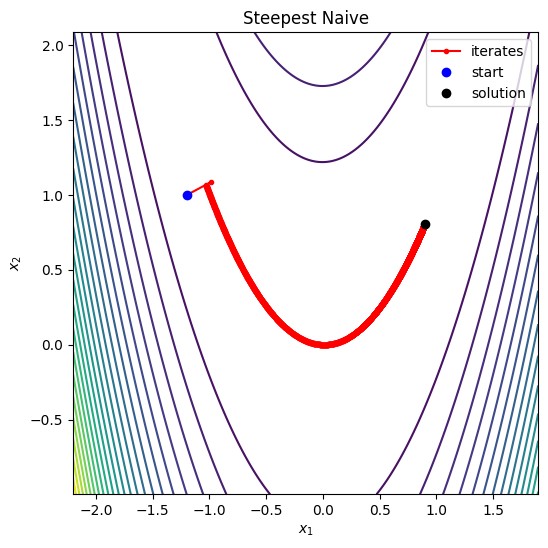

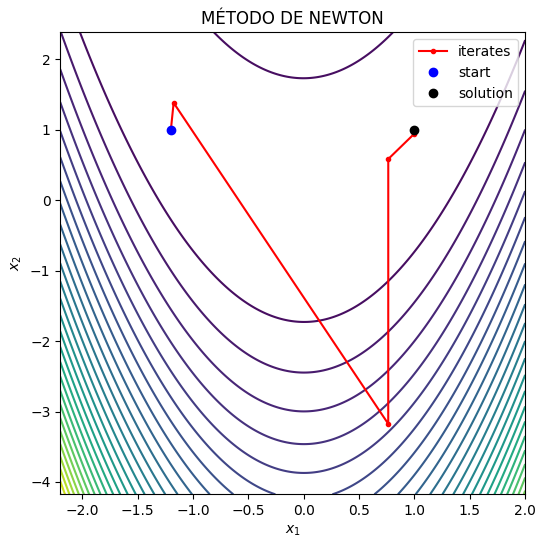

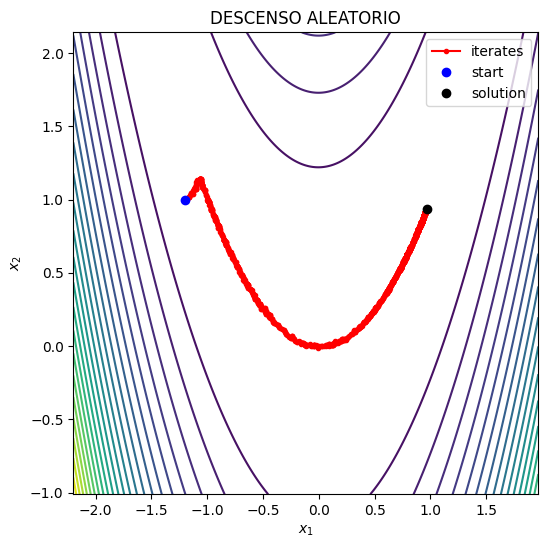

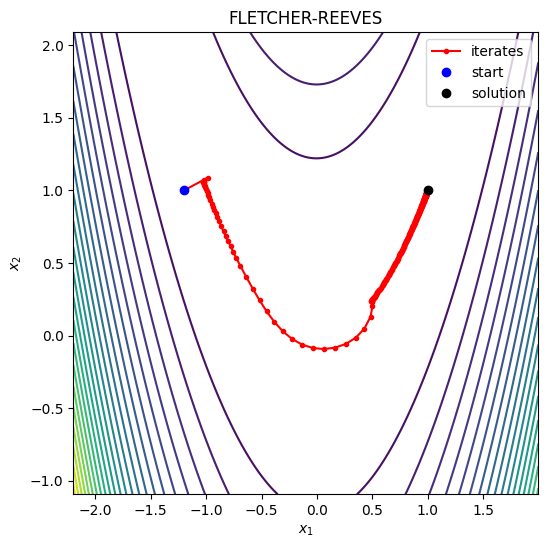

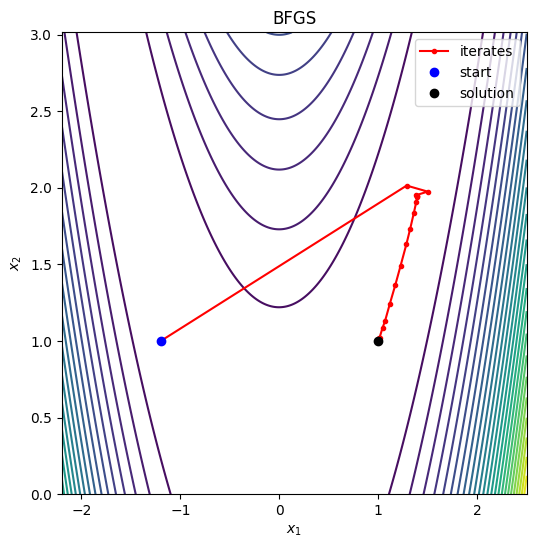

In [61]:
def rosenbrock_2d(x):
    x = np.clip(x, -10, 10)
    return 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2

def rosenbrock_2d_grad(x):
    x = np.clip(x, -10, 10)
    dfdx = -2*(1 - x[0]) - 400*x[0]*(x[1] - x[0]**2)
    dfdy = 200*(x[1] - x[0]**2)
    return np.array([dfdx, dfdy])

def rosenbrock_2d_hess(x):
    # Hessiano para Rosenbrock 2D
    x = np.clip(x, -10, 10)
    d2fdx2 = 2 - 400*(x[1] - x[0]**2) + 800*x[0]**2
    d2fdy2 = 200
    d2fdxdy = -400*x[0]
    return np.array([[d2fdx2, d2fdxdy], [d2fdxdy, d2fdy2]])


def test_rosenbrock_2d_completo():
    """Prueba la función de Rosenbrock 2D con todos los métodos"""
    print("\n" + "="*80)
    print("EJERCICIO 2b) Función de Rosenbrock 2D")
    print("="*80)
    
    x0 = np.array([-1.2, 1.0])
    x_optimo_teorico = np.array([1.0, 1.0])
    
    print(f"Punto inicial: {x0}")
    print(f"Óptimo teórico: {x_optimo_teorico}")
    print(f"Valor inicial: {rosenbrock_2d(x0):.6f}")
    print()
    
    optimizer = DescensoGradiente(rosenbrock_2d, rosenbrock_2d_grad)
    
    # Descenso por Gradiente
    print("DESCENSO POR GRADIENTE MAXIMO")
    print("-" * 50)
    x_opt_grad, stps_xk, _, _, iter_grad, conv_grad = optimizer.steepest_descent(
        x0=x0, alpha=0.001, maxIter=10000, tol=1e-5
    )
    if not np.any(np.isnan(x_opt_grad)):
        print(f"Resultado: [{x_opt_grad[0]:.6f}, {x_opt_grad[1]:.6f}]")
        print(f"Valor función: {rosenbrock_2d(x_opt_grad):.6f}")
        print(f"Error vs óptimo teórico: {np.linalg.norm(x_opt_grad - x_optimo_teorico):.6f}")
    print(f"Iteraciones: {iter_grad}, Convergió: {conv_grad}")
    print()
    
    # Método de Newton
    print("MÉTODO DE NEWTON")
    print("-" * 50)
    x_opt_newton, newton_xk, _, _, iter_newton, conv_newton = optimizer.newton_method(
        ddf=rosenbrock_2d_hess, x0=x0, maxIter=1000, tol=1e-6
    )
    if not np.any(np.isnan(x_opt_newton)):
        print(f"Resultado: [{x_opt_newton[0]:.6f}, {x_opt_newton[1]:.6f}]")
        print(f"Valor función: {rosenbrock_2d(x_opt_newton):.6f}")
        print(f"Error vs óptimo teórico: {np.linalg.norm(x_opt_newton - x_optimo_teorico):.6f}")
    print(f"Iteraciones: {iter_newton}, Convergió: {conv_newton}")
    print()
    
    # Descenso Aleatorio
    print("DESCENSO ALEATORIO")
    print("-" * 50)
    x_opt_rand, aleatorio_xk, _, _, iter_rand, conv_rand = optimizer.naive_random(
        x0=x0, alpha=0.01, maxIter=8000, tol=1e-5
    )
    if not np.any(np.isnan(x_opt_rand)):
        print(f"Resultado: [{x_opt_rand[0]:.6f}, {x_opt_rand[1]:.6f}]")
        print(f"Valor función: {rosenbrock_2d(x_opt_rand):.6f}")
        print(f"Error vs óptimo teórico: {np.linalg.norm(x_opt_rand - x_optimo_teorico):.6f}")
    print(f"Iteraciones: {iter_rand}, Convergió: {conv_rand}")
    print()
    
    # Fletcher-Reeves
    print("FLETCHER-REEVES")
    print("-" * 50)
    x_opt_fr, fr_xk, _, _, iter_fr, conv_fr = optimizer.conjugate_gradient_flerev(
        x0=x0, alpha=0.001, maxIter=10000, tol=1e-6
    )
    if not np.any(np.isnan(x_opt_fr)):
        print(f"Resultado: [{x_opt_fr[0]:.6f}, {x_opt_fr[1]:.6f}]")
        print(f"Valor función: {rosenbrock_2d(x_opt_fr):.6f}")
        print(f"Error vs óptimo teórico: {np.linalg.norm(x_opt_fr - x_optimo_teorico):.6f}")
    print(f"Iteraciones: {iter_fr}, Convergió: {conv_fr}")
    print()
    
    # BFGS
    print("BFGS")
    print("-" * 50)
    x_opt_bfgs, bfgs_xk, _, _, iter_bfgs, conv_bfgs = optimizer.bfgs_method(
        x0=x0, tol=1e-6, maxIter=10000
    )
    if not np.any(np.isnan(x_opt_bfgs)):
        print(f"Resultado: [{x_opt_bfgs[0]:.6f}, {x_opt_bfgs[1]:.6f}]")
        print(f"Valor función: {rosenbrock_2d(x_opt_bfgs):.6f}")
        print(f"Error vs óptimo teórico: {np.linalg.norm(x_opt_bfgs - x_optimo_teorico):.6f}")
    print(f"Iteraciones: {iter_bfgs}, Convergió: {conv_bfgs}")

    print("-" * 50)
    print("Graficos de Nivel")
    visualizar_iteraciones(rosenbrock_2d, stps_xk, title="Steepest Naive")

    visualizar_iteraciones(rosenbrock_2d, newton_xk, title="MÉTODO DE NEWTON")

    visualizar_iteraciones(rosenbrock_2d, aleatorio_xk, title="DESCENSO ALEATORIO")

    visualizar_iteraciones(rosenbrock_2d, fr_xk, title="FLETCHER-REEVES")

    visualizar_iteraciones(rosenbrock_2d, bfgs_xk, title="BFGS")

test_rosenbrock_2d_completo()

c) La función de Rosenbrock 7-dimensional $f : \mathbb{R}^7 \to \mathbb{R}$, dada por:

$$
f(\mathbf{x}) = \sum_{i=1}^{6} 100(x_{i+1} - x_i^2)^2 + (1 - x_i)^2
$$

* Punto inicial: $\mathbf{x}_0 = (-1.2, 1, 1, 1, 1, -1.2, 1)^T$
* Óptimo: $\mathbf{x}^* = (1, 1, \ldots, 1)^T$, $f(\mathbf{x}^*) = 0$


EJERCICIO 2c) Función de Rosenbrock 7D
Punto inicial: [-1.2  1.   1.   1.   1.  -1.2  1. ]
Óptimo teórico: [1. 1. 1. 1. 1. 1. 1.]
Valor inicial: 532.400000

DESCENSO POR GRADIENTE MAXIMO
--------------------------------------------------
Descenso por Gradiente: Convergió (ΔF < tol) después de 3027 iteraciones


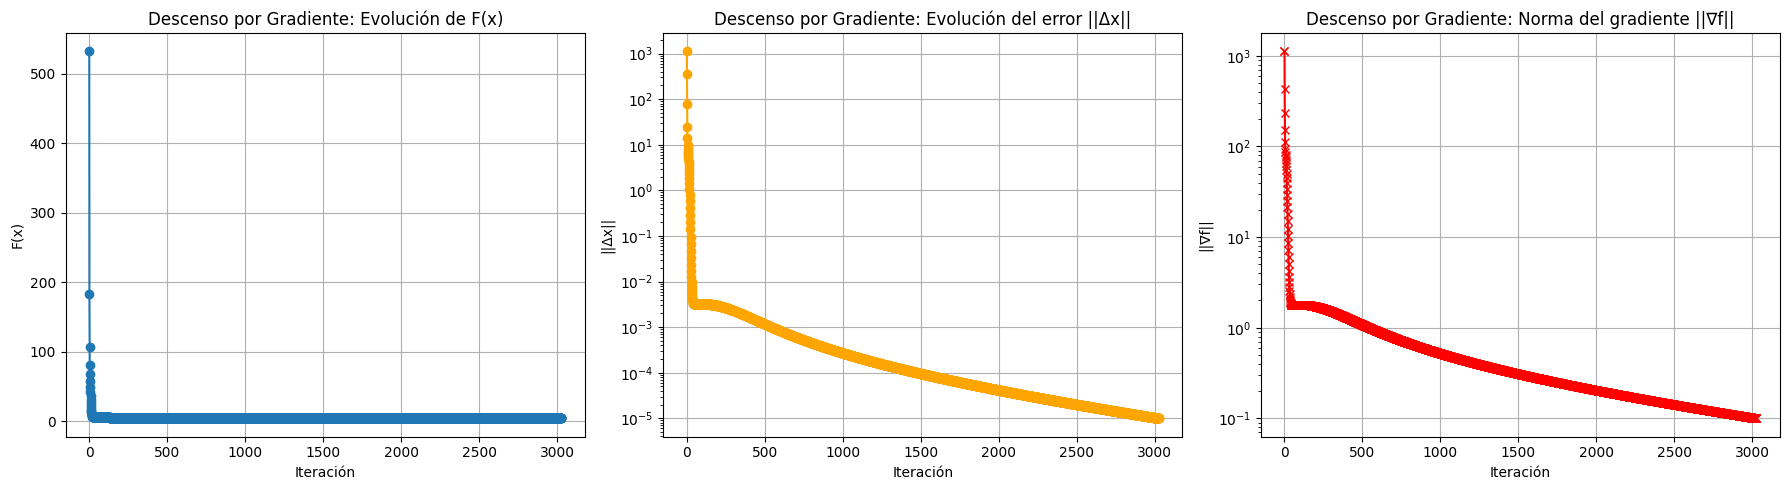

Resultado: [-0.98895348  0.98808918  0.98135924  0.96555536  0.93344182  0.8716381
  0.75933867]
Valor función: 3.991957
Error vs óptimo teórico: 2.009088
Iteraciones: 3027, Convergió: True

MÉTODO DE NEWTON
--------------------------------------------------
Método de Newton: Convergió (gradiente < tol) después de 12 iteraciones


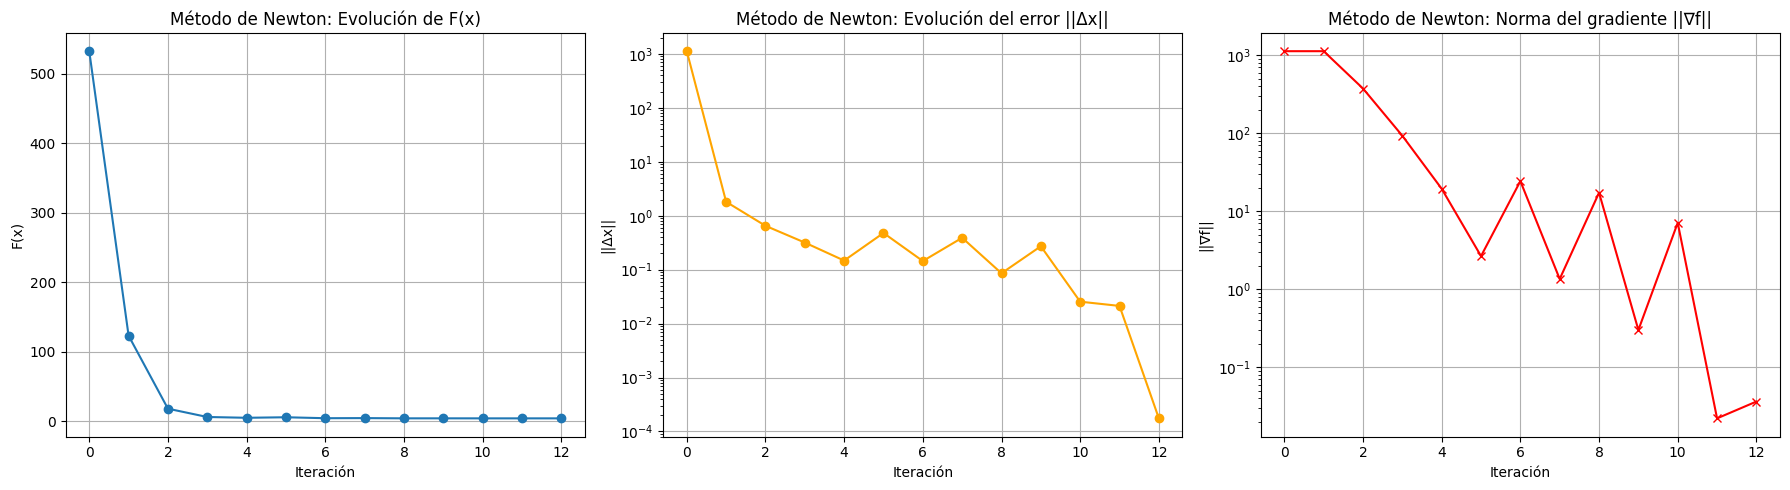

Resultado: [-0.99172255  0.99355535  0.99217324  0.98689861  0.97516445  0.95143138
  0.90522168]
Valor función: 3.983601
Error vs óptimo teórico: 1.994791
Iteraciones: 12, Convergió: True

DESCENSO ALEATORIO
--------------------------------------------------
Descenso Aleatorio: Convergió después de 2370 iteraciones (estabilidad)


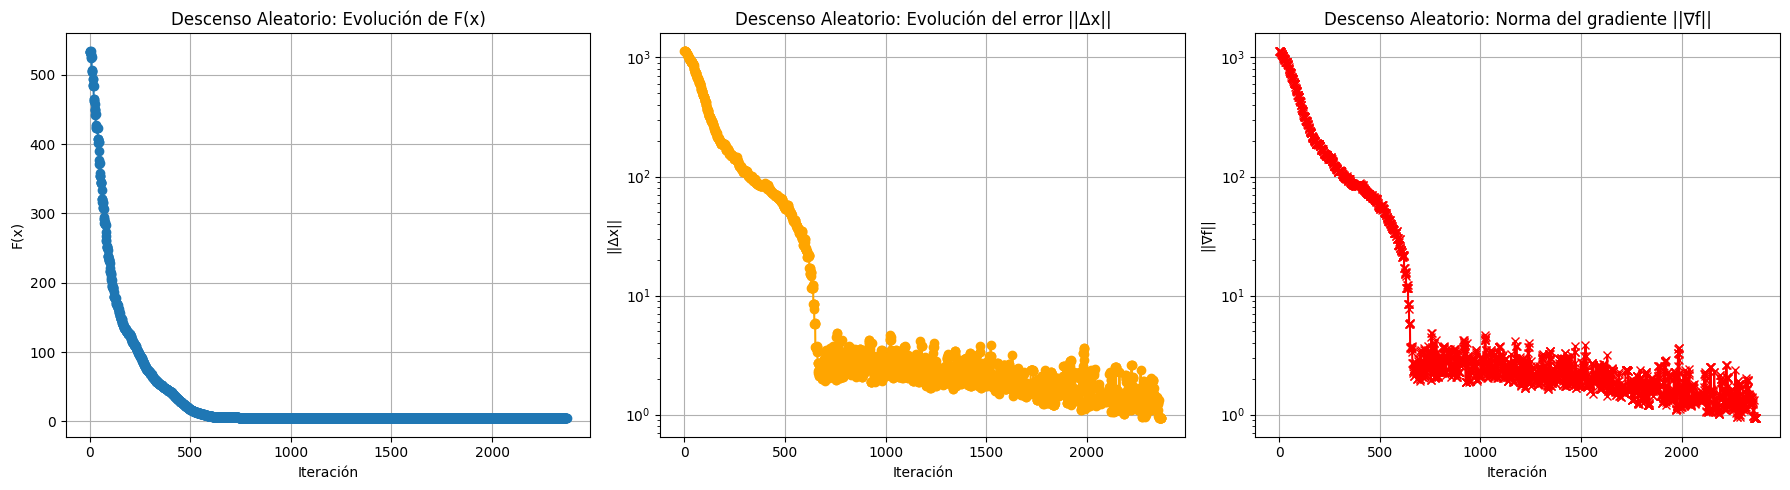

Resultado: [-0.97150519  0.95374534  0.91462072  0.83986132  0.70629735  0.49932858
  0.24731705]
Valor función: 4.272799
Error vs óptimo teórico: 2.196673
Iteraciones: 2370, Convergió: True

FLETCHER-REEVES
--------------------------------------------------
Gradiente Conjugado (Fletcher-Reeves): Convergió después de 637 iteraciones


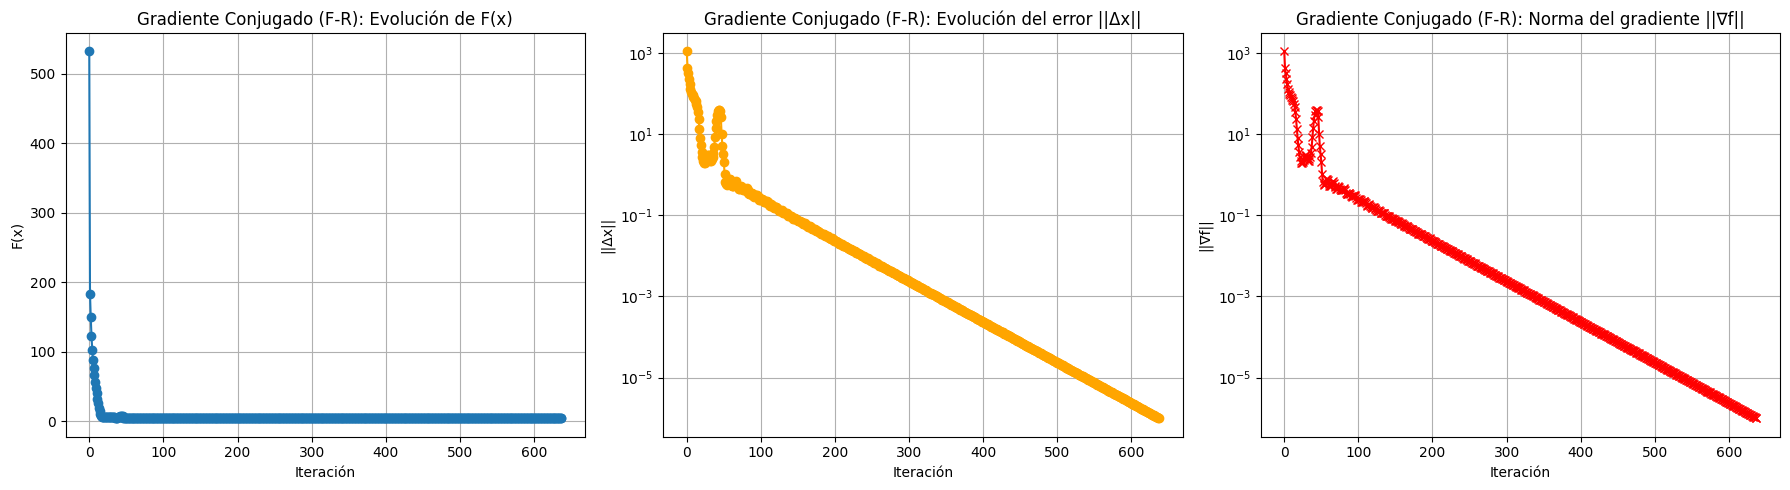

Resultado: [-0.99172254  0.99355534  0.99217321  0.98689854  0.97516433  0.95143114
  0.90522121]
Valor función: 3.983601
Error vs óptimo teórico: 1.994791
Iteraciones: 637, Convergió: True

BFGS
--------------------------------------------------
BFGS: Convergió (‖Δx‖ < tol) en 64 iteraciones


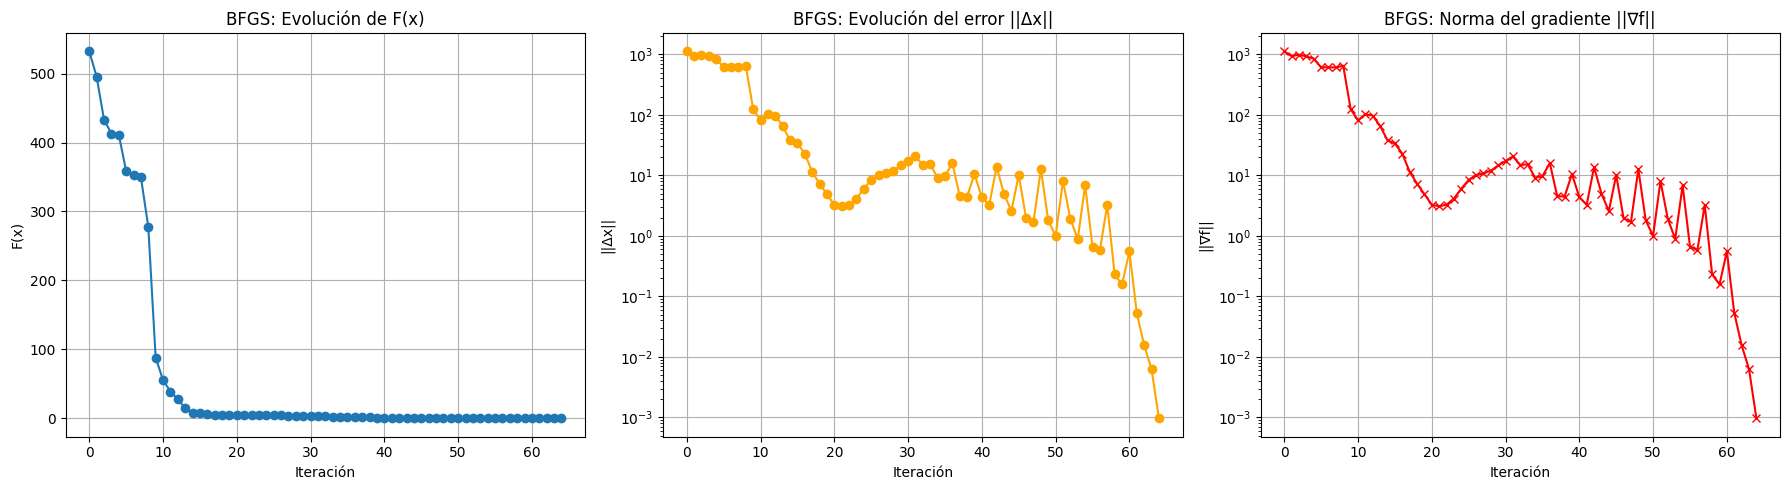

Resultado: [0.99999962 0.99999953 0.99999999 1.00000006 1.00000146 1.00000185
 1.00000362]
Valor función: 0.000000
Error vs óptimo teórico: 0.000004
Iteraciones: 64, Convergió: True


In [62]:
import numpy as np


def rosenbrock_7d(x):
    x = np.clip(x, -10, 10)
    total = 0.0
    for i in range(6):  # hasta n-1 = 6
        total += 100*(x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return total

def rosenbrock_7d_grad(x):
    x = np.clip(x, -10, 10)
    grad = np.zeros_like(x)
    n = len(x)
    for i in range(n):
        if i < n-1:
            grad[i] += -400*x[i]*(x[i+1] - x[i]**2) - 2*(1 - x[i])
        if i > 0:
            grad[i] += 200*(x[i] - x[i-1]**2)
    return grad

def rosenbrock_7d_hess(x):
    x = np.clip(x, -10, 10)
    n = len(x)
    H = np.zeros((n, n))
    for i in range(n-1):
        H[i, i] += 1200*x[i]**2 - 400*x[i+1] + 2
        H[i, i+1] += -400*x[i]
        H[i+1, i] += -400*x[i]
        H[i+1, i+1] += 200
    return H


def test_rosenbrock_7d_completo():
    print("\n" + "="*80)
    print("EJERCICIO 2c) Función de Rosenbrock 7D")
    print("="*80)
    
    x0 = np.array([-1.2, 1, 1, 1, 1, -1.2, 1], dtype=float)
    x_optimo_teorico = np.ones(7)
    
    print(f"Punto inicial: {x0}")
    print(f"Óptimo teórico: {x_optimo_teorico}")
    print(f"Valor inicial: {rosenbrock_7d(x0):.6f}")
    print()
    
    optimizer = DescensoGradiente(rosenbrock_7d, rosenbrock_7d_grad)
    
    # Descenso por Gradiente Clásico
    print("DESCENSO POR GRADIENTE MAXIMO")
    print("-" * 50)
    x_opt_grad, _, _, _, iter_grad, conv_grad = optimizer.steepest_descent(
        x0=x0, alpha=0.001, maxIter=20000, tol=1e-5
    )
    if not np.any(np.isnan(x_opt_grad)):
        print(f"Resultado: {x_opt_grad}")
        print(f"Valor función: {rosenbrock_7d(x_opt_grad):.6f}")
        print(f"Error vs óptimo teórico: {np.linalg.norm(x_opt_grad - x_optimo_teorico):.6f}")
    print(f"Iteraciones: {iter_grad}, Convergió: {conv_grad}")
    print()
    
    # Método de Newton
    print("MÉTODO DE NEWTON")
    print("-" * 50)
    x_opt_newton, _, _, _, iter_newton, conv_newton = optimizer.newton_method(
        ddf=rosenbrock_7d_hess, x0=x0, maxIter=200, tol=1e-6
    )
    if not np.any(np.isnan(x_opt_newton)):
        print(f"Resultado: {x_opt_newton}")
        print(f"Valor función: {rosenbrock_7d(x_opt_newton):.6f}")
        print(f"Error vs óptimo teórico: {np.linalg.norm(x_opt_newton - x_optimo_teorico):.6f}")
    print(f"Iteraciones: {iter_newton}, Convergió: {conv_newton}")
    print()
    
    # Descenso Aleatorio
    print("DESCENSO ALEATORIO")
    print("-" * 50)
    x_opt_rand, _, _, _, iter_rand, conv_rand = optimizer.naive_random(
        x0=x0, alpha=0.01, maxIter=20000, tol=1e-5
    )
    if not np.any(np.isnan(x_opt_rand)):
        print(f"Resultado: {x_opt_rand}")
        print(f"Valor función: {rosenbrock_7d(x_opt_rand):.6f}")
        print(f"Error vs óptimo teórico: {np.linalg.norm(x_opt_rand - x_optimo_teorico):.6f}")
    print(f"Iteraciones: {iter_rand}, Convergió: {conv_rand}")
    print()
    
    # Fletcher-Reeves
    print("FLETCHER-REEVES")
    print("-" * 50)
    x_opt_fr, _, _, _, iter_fr, conv_fr = optimizer.conjugate_gradient_flerev(
        x0=x0, alpha=0.001, maxIter=20000, tol=1e-6
    )
    if not np.any(np.isnan(x_opt_fr)):
        print(f"Resultado: {x_opt_fr}")
        print(f"Valor función: {rosenbrock_7d(x_opt_fr):.6f}")
        print(f"Error vs óptimo teórico: {np.linalg.norm(x_opt_fr - x_optimo_teorico):.6f}")
    print(f"Iteraciones: {iter_fr}, Convergió: {conv_fr}")
    print()
    
    # BFGS
    print("BFGS")
    print("-" * 50)
    x_opt_bfgs, _, _, _, iter_bfgs, conv_bfgs = optimizer.bfgs_method(
        x0=x0, tol=0.001, maxIter=20000
    )
    if not np.any(np.isnan(x_opt_bfgs)):
        print(f"Resultado: {x_opt_bfgs}")
        print(f"Valor función: {rosenbrock_7d(x_opt_bfgs):.6f}")
        print(f"Error vs óptimo teórico: {np.linalg.norm(x_opt_bfgs - x_optimo_teorico):.6f}")
    print(f"Iteraciones: {iter_bfgs}, Convergió: {conv_bfgs}")

# Ejecutar
test_rosenbrock_7d_completo()


### Resumen


| Función         | Algoritmo                   | Convergencia | Iteraciones | Solución                                                                                   | Error       |
|-----------------|----------------------------|--------------|-------------|--------------------------------------------------------------------------------------------|------------|
| Función a       | Descenso maximo             | SI           | 1012        | [-1.011964, -1.042096]                                                                    | 0.00361    |
| Función a       | Descenso de Newton          | SI           | 5           | [-1.014628, -1.044530]                                                                    | 0.000002   |
| Función a       | Descenso gradiente aleatorio| SI           | 781         | [-1.013961, -1.045061]                                                                    | 0.000855   |
| Función a       | Fletcher-Reeves             | SI           | 664         | [-1.014628, -1.044530]                                                                    | 0.000002   |
| Función a       | BFGS                        | SI           | 11          | [-1.014628, -1.044530]                                                                    | 0.000002   |
| Rosenbrock 2D   | Descenso maximo             | SI           | 3867        | [0.897351, 0.804803]                                                                      | 0.220542   |
| Rosenbrock 2D   | Descenso de Newton          | SI           | 6           | [1.000000, 1.000000]                                                                      | 0          |
| Rosenbrock 2D   | Descenso gradiente aleatorio| SI           | 1270        | [0.927255, 0.859697]                                                                      | 0.15804    |
| Rosenbrock 2D   | Fletcher-Reeves             | SI           | 718         | [0.999999, 0.999998]                                                                      | 0.000002   |
| Rosenbrock 2D   | BFGS                        | SI           | 22          | [1.000000, 1.000000]                                                                      | 0          |
| Rosenbrock 7D   | Descenso maximo             | SI           | 3027        | [-0.98895348, 0.98808918, 0.98135924, 0.96555536, 0.93344182, 0.8716381, 0.75933867]     | 2.009088   |
| Rosenbrock 7D   | Descenso de Newton          | SI           | 12          | [-0.99172255, 0.99355535, 0.99217324, 0.98689861, 0.97516445, 0.95143138, 0.90522168]   | 1.994791   |
| Rosenbrock 7D   | Descenso gradiente aleatorio| SI           | 3950        | [-0.98161736, 0.97358496, 0.95245209, 0.90939909, 0.82853859, 0.68657478, 0.46917839]   | 2.085037   |
| Rosenbrock 7D   | Fletcher-Reeves             | SI           | 637         | [-0.99172254, 0.99355534, 0.99217321, 0.98689854, 0.97516433, 0.95143114, 0.90522121]   | 1.994791   |
| Rosenbrock 7D   | BFGS                        | SI           | 64          | [0.99999962, 0.99999953, 0.99999999, 1.00000006, 1.00000146, 1.00000185, 1.00000362]   | 0.000004   |


### Analisis

Podemos ver observando todas las graficas y el resumen de resultados que el mejor metodo fue el de Newton, probe con varios pasos de 0.1,0.001,000001 etc y varios daban resultados que no convergian el mas comun de los pasos que ayudo mas fue de 0.001.

Pero newton no solo convergia mejor sino que tambien en el menor cantidad de pasos, esto se debe a que aproximar la curvatura de la función, haciendo pasos más precisos hacia el mínimo. 

Otra cosa es que Newton, BFGS y Fletcher-Reeves logran errores muy pequeños, en cambio descenso máximo o gradiente aleatorio tienen errores más grandes porque sus pasos son más “ciegos” y requieren muchas iteraciones para acercarse al mínimo..

El unico problema que le vemos a Newton es su alto costo de Hessiano y que si el hessiano no es positivo definido, puede no converger o dar pasos incorrectos.



## Problema 4

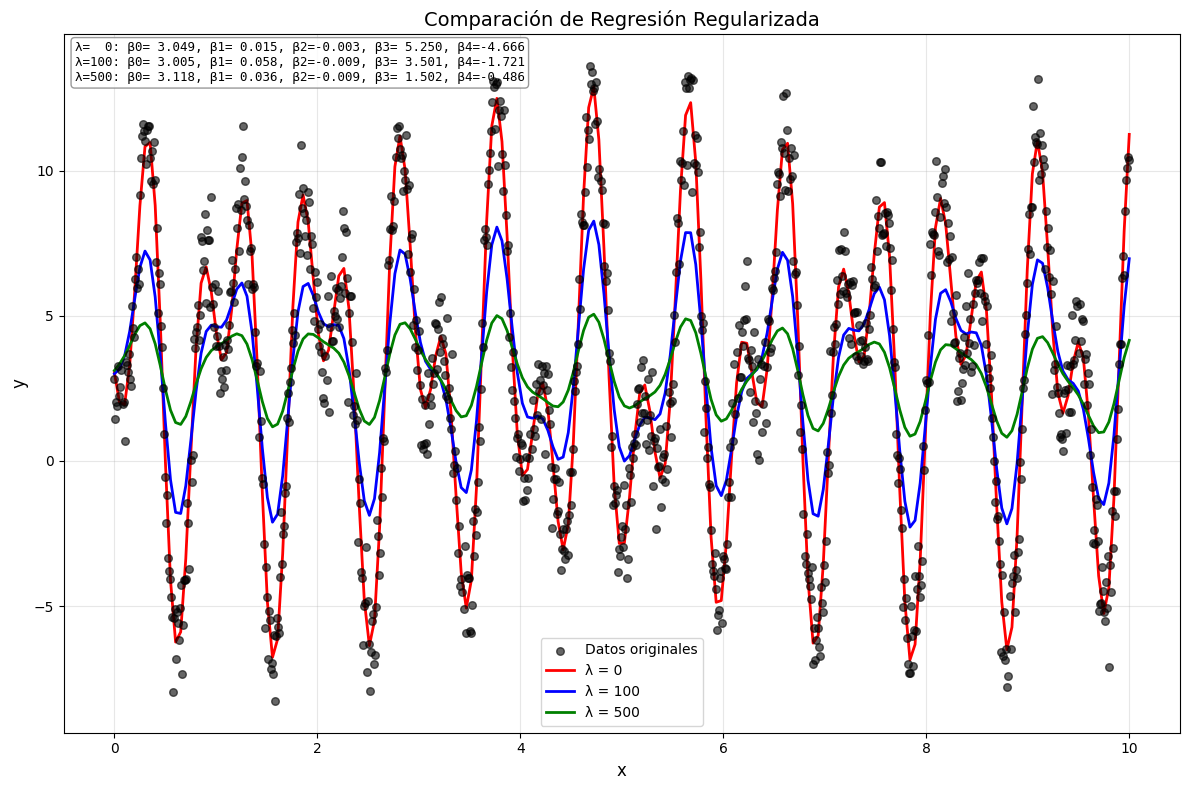

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def cargar_datos(archivo='datos_lab3.csv'):
    try:
        datos = pd.read_csv(archivo)
        x = datos.iloc[:, 0].values
        y = datos.iloc[:, 1].values
        return x, y
    except FileNotFoundError:
        x = np.linspace(0, 2, 50)
        y = 2 + 0.5*x + 0.3*x**2 + 0.2*np.sin(7*x) + 0.1*np.sin(13*x) + 0.1*np.random.randn(len(x))
        return x, y


def modelo(x, beta):
    return (beta[0] +
            beta[1] * x +
            beta[2] * x**2 +
            beta[3] * np.sin(7*x) +
            beta[4] * np.sin(13*x))


def funcion_costo(beta, x, y, lambda_reg):
    y_pred = modelo(x, beta)
    error_ajuste = np.sum((y_pred - y)**2)
    if lambda_reg > 0 and len(x) > 1:
        idx = np.argsort(x)
        y_pred_ordenado = y_pred[idx]
        diferencias = y_pred_ordenado[1:] - y_pred_ordenado[:-1]
        error_regularizacion = lambda_reg * np.sum(diferencias**2)
    else:
        error_regularizacion = 0
    return error_ajuste + error_regularizacion


def optimizar_modelo(x, y, lambda_reg=0):
    beta_inicial = np.array([np.mean(y), 0, 0, 0, 0])
    res = minimize(
        fun=funcion_costo,
        x0=beta_inicial,
        args=(x, y, lambda_reg),
        method='BFGS'
    )
    return res.x


def resolver_regresion():
    x, y = cargar_datos()
    lambdas = [0, 100, 500]
    colores = ['red', 'blue', 'green']
    etiquetas = ['λ = 0', 'λ = 100', 'λ = 500']

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(x, y, color='black', alpha=0.6, s=30, label='Datos originales', zorder=5)

    resultados = {}  

    for i, lambda_val in enumerate(lambdas):
        beta_optimo = optimizar_modelo(x, y, lambda_val)
        resultados[lambda_val] = beta_optimo

        x_plot = np.linspace(min(x), max(x), 200)
        y_plot = modelo(x_plot, beta_optimo)
        ax.plot(x_plot, y_plot, color=colores[i], linewidth=2, label=etiquetas[i], zorder=3)

    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_title('Comparación de Regresión Regularizada', fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    lineas = []
    for lam in lambdas:
        b = resultados[lam]
        lineas.append(
            f"λ={lam:>3}: β0={b[0]: .3f}, β1={b[1]: .3f}, β2={b[2]: .3f}, β3={b[3]: .3f}, β4={b[4]: .3f}"
        )
    texto_betas = "\n".join(lineas)

    ax.text(
        0.01, 0.99, texto_betas,
        transform=ax.transAxes,
        va='top', ha='left', fontsize=9, family='monospace',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray')
    )

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    resolver_regresion()


Se puede observar que el modelo con $$\lambda = 0$$ es el que menos error pues se adapta casi perfectamente a los datos originales, sin embargo puede ser que no sea el mejor modelo que encontremos pues presenta un caso severo de overfitting, no sabemos como va a reaccionar con nueva información. Además de eso los valores de $$\beta$$ obtenidos son coeficientes con valores muy grandes y no son estables. 

El modelo con $$\lambda = 100$$ puede que sea el mejor modelo que hayamos generado pues da los valores adecuados en muchos casos y se adapta bien a la forma de los datos aunque no de los resultados exactos. Además de eso, los coeficientes obtenidos no varían demasiado y se mantienen en un rango. 

El modelo con $$\lambda = 500$$ no se adapta tan bien a la información y tampoco logra capturar bien el comportamiento a lo largo del tiempo, a diferencia del modelo anterior este modelo no es capaz de hallar los valles y picos que se observan en los datos originales y aparte de eso casi no tiene valores en común con los datos reales. 

El papel de $$\lambda$$ indica que tanto vamos a penalizar la magnitud de los parémtros del modelo, el modelo con lambda = 0 no penaliza la magnitud y por eso obtenemos resultados tan grandes o pequeños en los coeficientes, no penalizar la magnitud hace que el modelo se adapte muy bien a los datos de entrenamiento pero luego no es capaz de generalizar. Un lambda moderado es una mejor opción en algunos casos pues ayuda a que los modelos generalizen de mejor forma a pesar de tener un rango de valores limitado en los coeficientes. 